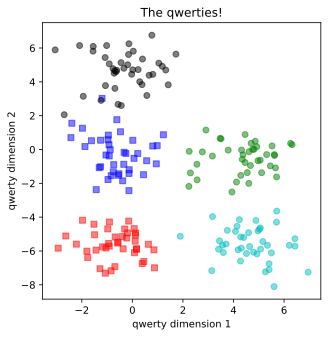

In [ ]:
import numpy as np
from jagpascoe_ML_toolkit.createDataFunctions import createQwerties, splitData
data, labels = createQwerties(clusters=5, nPerClust=40, blur=1.0, centroids=np.array([[0,0],[0,5],[0,-5],[5,0],[5,-5]]), draw=True)


In [3]:

train_loader, dev_loader, test_loader = splitData(partitions=[0.85,0.075], batch_size=30, data=data, labels=labels, verbose=True)

   Total data size: torch.Size([200, 2])

Training data size: torch.Size([170, 2])
Trainning Label data size: torch.Size([170])
Dev data size: torch.Size([14, 2])
Dev Label data size: torch.Size([14])
Dev test size: torch.Size([16, 2])
Dev test data size: torch.Size([16])


In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt

class mClass(nn.Module):
    '''
    this Class models a Multi classificator in Pytorch
    '''
  

    def __init__(self, nImputs, nOutputs, hidden, nHidden, dr=0.0):
      super().__init__()

      #Create a dictionary to save the layers
      self.layers = nn.ModuleDict()
      self.nImputs = nImputs
      self.nOutputs = nOutputs
      self.hidden = hidden
      self.nHidden = nHidden
      self.dr = dr #Dropuot rate

      self.trainAcc = [] #for storing the accuracy vectors of trainning and dev
      self.devAcc = []
      self.losses = [] #for storing losses at trainning

      #This two vectors are for measure weight changes and withconds of the learnig process
      self.weightChanges = [] #This counts about how much is learning in each epoch
      self.weightConds = [] #this how much is specializing in anykind of particularlity
      
      ### input layer
      self.layers["input"] = nn.Linear(nImputs,nHidden)

      for h in range(self.hidden):      
      ### hidden layer
        self.layers[f'hidden{h}'] = nn.Linear(nHidden,nHidden)

      ### output layer
      self.layers['output'] = nn.Linear(nHidden,nOutputs)

    # forward pass
      x = F.leaky_relu( self.layers['input'](x) )
      x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
   
      for h in range(self.hidden):
        x = F.leaky_relu( self.layers[f'hidden{h}'](x) )
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
      return self.layers['output'](x)

    def testModel(self, n, test_loader):
      # extract X,y from test dataloader
      X,y = next(iter(test_loader)) 
      self.load_state_dict(n['net'])
      yHat = self.forward(X)
      bestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
      return(bestAcc)


    def funtion2trainTheModel(self, train_loader, dev_loader, numepochs = 100, learningRate=0.01, draw=True):
      # New! initialize a dictionary for the best model
      theBestModel = {'Accuracy':0, 'net':None, 'epoch':0} #net will be the whole model instance

      # loss function
      self.lossfun = nn.CrossEntropyLoss()

      # optimizer
      self.optimizer = torch.optim.SGD(self.parameters(), learningRate)


      # initialize losses
      losses   = torch.zeros(numepochs)
      trainAcc = []
      devAcc   = []

      # loop over epochs
      for epochi in range(numepochs):

        # switch on training mode
        self.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

          # forward pass and loss
          yHat = self.forward(X)
          loss = self.lossfun(yHat,y)

          # backprop
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          # loss from this batch
          batchLoss.append(loss.item())

          # compute accuracy
          matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
          matchesNumeric = matches.float()             # convert to numbers (0/1)
          accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
          batchAcc.append( accuracyPct )               # add to list of accuracies
          # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        self.eval()
        X,y = next(iter(dev_loader)) # extract X,y from devset dataloader
        with torch.no_grad(): # deactivates autograd
          yHat = self.forward(X)
      
        # compare the following really long line of code to the training accuracy lines
        devAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


        # New! Store this model if it's the best so far
        if devAcc[-1]>theBestModel['Accuracy']:
      
          # new best accuracy
          theBestModel['Accuracy'] = devAcc[-1].item()
      
          # epoch iteration
          theBestModel['epoch'] = epochi

          # model's internal state
          theBestModel['net'] = copy.deepcopy( self.state_dict() ) #here update the best model
      
        # end epochs
      if(draw):
        #plot results of trainning
        fig,ax = plt.subplots(1,2,figsize=(16,5))
        ax[0].plot(losses.detach(),'o-')
        ax[0].set_ylabel('Loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_title('Losses')

        ax[1].plot(trainAcc,'o-',label='Train')
        ax[1].plot(devAcc,'o-',label='Devset')
        ax[1].set_ylabel('Accuracy (%)')
        ax[1].set_xlabel('Epoch')
        ax[1].set_title('Accuracy')
        #ax[1].set_ylim([85,95])
        #ax[1].set_xlim([80,105])
        ax[1].legend()
        plt.show()

      # function output
      return trainAcc,devAcc,losses,theBestModel

In [5]:
clusters=5
n = mClass(nImputs=2, nOutputs=clusters, hidden = 1, nHidden = 8)
trainAcc,devAcc,losses,theBestModel = n.funtion2trainTheModel(train_loader=train_loader, dev_loader=dev_loader, numepochs=150, learningRate=0.05, draw=True)